# **NLP Project: Analyzing and Predicting Salary from Job Description**

*Master in Machine Learning for Health, 2023~2024*

*Authors: Daniel Corrales, Jaime Fernández & Rafael Rodríguez*

---

In [1]:
# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as scsp
import networkx as nx
import subprocess
import pickle
import warnings
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
import spacy
import gensim
print(spacy.__version__)

3.7.4


In [7]:
# Download spaCy model
!python -m spacy download en_core_web_md # Or other

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## **0. Data Loading**

In [8]:
path = '/content/drive/MyDrive/Natural Language Processing/Project'
df_jobs = pd.read_csv(path + '/processed/jobs_processed.csv')

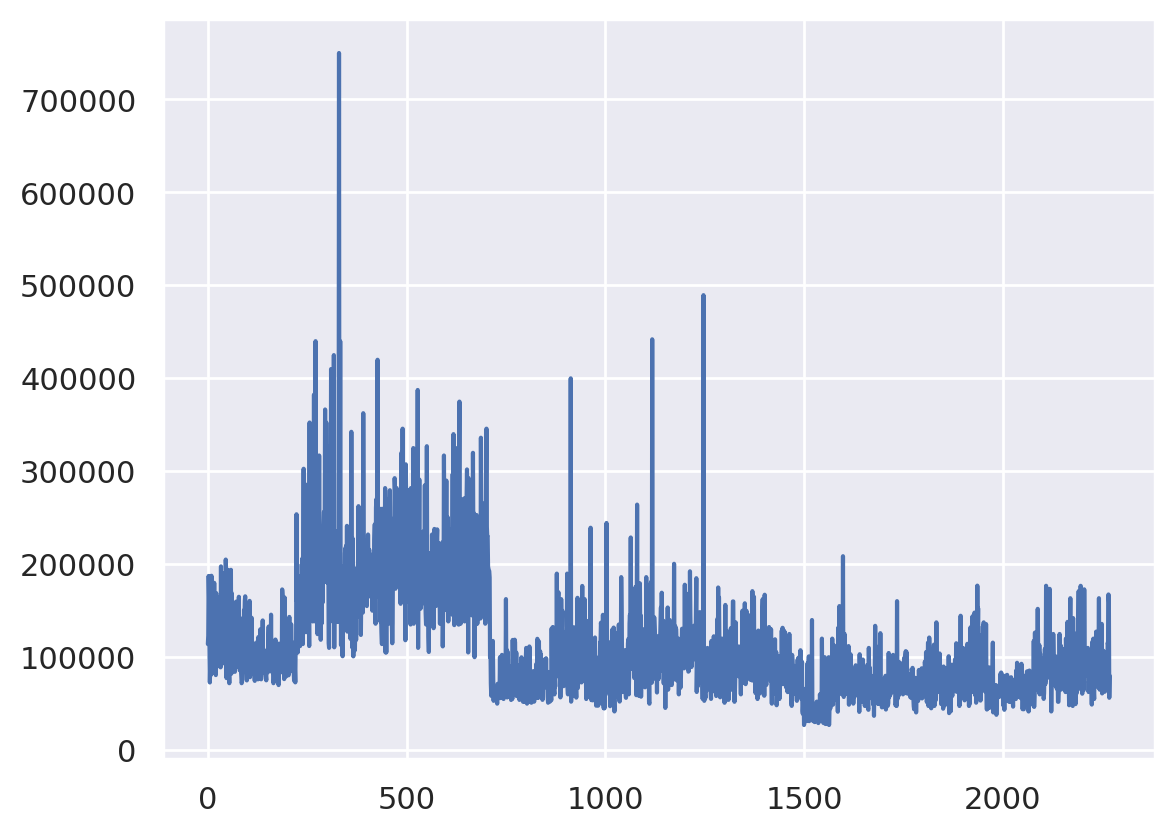

In [9]:
plt.plot(df_jobs["avg_pay"])

(array([134., 604., 512., 337., 181., 138., 118.,  87.,  64.,  36.,  20.,
         10.,  10.,   6.,   4.,   2.,   2.,   3.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 27040.        ,  51138.66666667,  75237.33333333,  99336.        ,
        123434.66666667, 147533.33333333, 171632.        , 195730.66666667,
        219829.33333333, 243928.        , 268026.66666667, 292125.33333333,
        316224.        , 340322.66666667, 364421.33333333, 388520.        ,
        412618.66666667, 436717.33333333, 460816.        , 484914.66666667,
        509013.33333333, 533112.        , 557210.66666667, 581309.33333333,
        605408.        , 629506.66666667, 653605.33333333, 677704.        ,
        701802.66666667, 725901.33333333, 750000.        ]),
 <BarContainer object of 30 artists>)

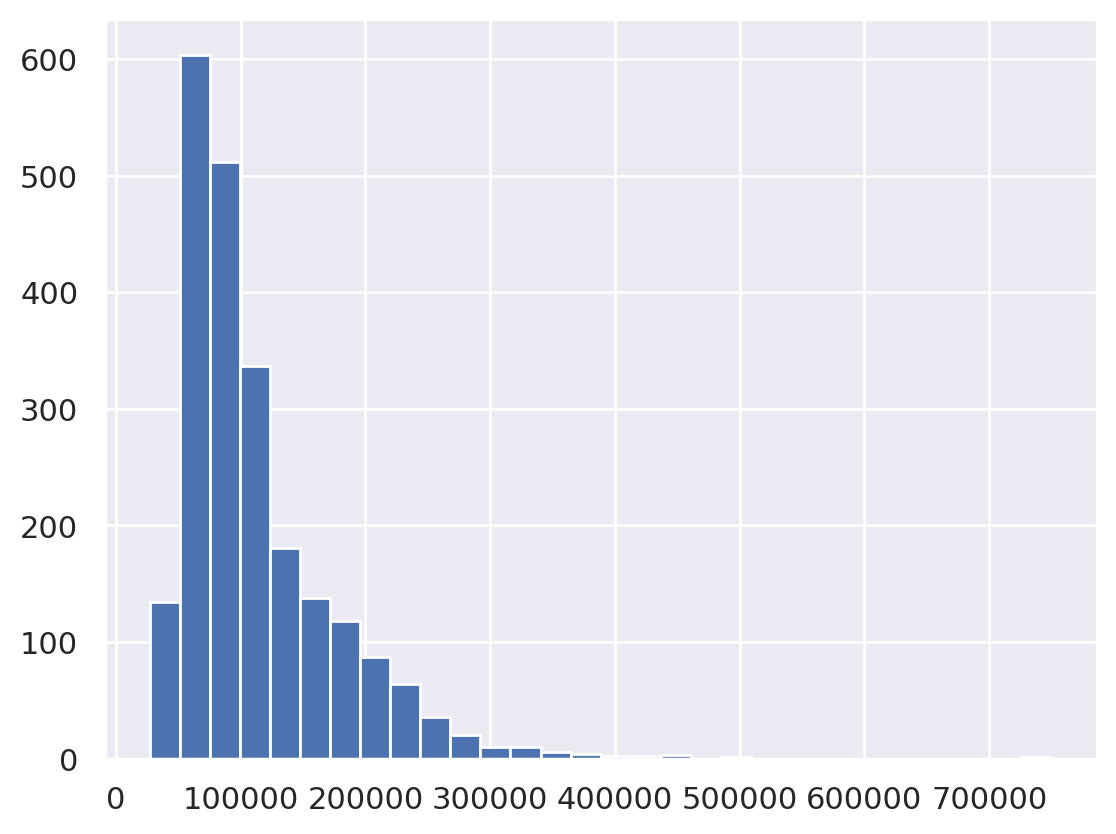

In [10]:
plt.hist(df_jobs["avg_pay"], bins = 30)

In [11]:
df_jobs["avg_pay"].mean() + 4*df_jobs["avg_pay"].std()

366420.2664467064

In [12]:
df_jobs.drop(df_jobs[df_jobs["avg_pay"] > df_jobs["avg_pay"].mean() + 4*df_jobs["avg_pay"].std()].index, inplace = True)

We work with the `full_info` column as input data and the `avg_pay` column as target column.

In [13]:
corpus = df_jobs['full_info'].to_list()
avg_pay = df_jobs['avg_pay'].to_list()

print(f"Number of job offers: {len(corpus)}")

Number of job offers: 2257


Let's print an example to chechk everything is working properly.

In [14]:
idx = 1000
print(f"Average pay: {avg_pay[idx]}\n")
print(corpus[idx])

Average pay: 104892.0

Job title: EDUCATION PROGRAMS CONSULTANT. Company name: Department of Education.                                         Location: Sacramento County, CA. Job type: Full-time. Job Description and Duties
The California Department of Education (CDE), Charter Schools Division (Division) is seeking a motivated, analytical, and detail-oriented individual to join the California State Board of Education (SBE) Oversight and Technical Assistance Office! The SBE Oversight and Technical Assistance Office offers a collaborative, supportive, and flexible work environment with the option to work from home.

 Under the general supervision of the Education Administrator I of the SBE Oversight and Technical Assistance Office, and working cooperatively throughout the CDE, the Education Programs Consultant duties include, but are not limited to, the following:

Directly monitor ongoing operations of SBE-authorized charter schools, including analyzing academic, financial and complian

In [15]:
with open(path + '/vectorizations/bow_corpus.pkl', 'rb') as f:
    corpus_bow_dense = pickle.load(f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'rb') as f:
    corpus_tfidf_dense = pickle.load(f)

with open(path + '/vectorizations/lemmatized_corpus.pkl', 'rb') as f:
    lemmatized_corpus = pickle.load(f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'rb') as f:
    n_gram_corpus = pickle.load(f)

with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

# with open(path + '/vectorizations/wordemb_corpus.pkl', 'rb') as f:
#     wemb_corpus = pickle.load(f)

## **1. Preprocessing Pipeline**

Here we preprocess the corpus to obtain its lemmatized version and we perform N-gram detection.

In [16]:
nlp = spacy.load('en_core_web_md')
nlp.disable_pipe('parser')
nlp.disable_pipe('ner')

# Corpus list contains all documents (train, val and test)
lemmatized_corpus = [[tk.lemma_ for tk in nlp(doc.lower()) if (tk.is_alpha or tk.is_digit) \
                      and not tk.is_stop and not tk.is_punct] for doc in corpus]

avg_length = np.mean([len(lemmas) for lemmas in lemmatized_corpus])
print(f"Average number of lemmas per job offer: {avg_length}\n")
print(lemmatized_corpus[0])

Average number of lemmas per job offer: 460.7284005316792

['job', 'title', 'electrical', 'engineering', 'opportunity', 'university', 'graduate', 'company', 'microsoft', 'location', 'microsoft', 'way', 'redmond', 'wa', '98052', 'job', 'type', 'time', 'come', 'build', 'community', 'explore', 'passion', 'good', 'work', 'microsoft', 'thousand', 'university', 'student', 'corner', 'world', 'opportunity', 'allow', 'bring', 'aspiration', 'talent', 'potential', 'excitement', 'journey', 'ahead', 'electrical', 'engineer', 'microsoft', 'design', 'develop', 'modify', 'evaluate', 'component', 'electronic', 'device', 'involve', 'manipulation', 'transmission', 'storage', 'electricity', 'define', 'design', 'approach', 'implementation', 'schedule', 'technical', 'specification', 'parameter', 'device', 'partake', 'select', 'material', 'component', 'base', 'analysis', 'specification', 'reliability', 'opportunity', 'allow', 'develop', 'test', 'plan', 'direct', 'support', 'personnel', 'engineer', 'preparati

### N-gram Detection

In [17]:
# Firts step is to find N-grams to improve LDA's performance
n_gram_model = gensim.models.phrases.Phrases(lemmatized_corpus, min_count=30, threshold=20)
n_gram_corpus = [el for el in n_gram_model[lemmatized_corpus]]

# Display table with N-grams
n_gram_dict = {}
detected_n_grams = []

for doc in n_gram_corpus:
  for word in doc:
    if '_' in word:
      if word not in detected_n_grams:
        detected_n_grams.append(word)
        n_gram_dict[word] = 0

      n_gram_dict[word] += 1

n_grams_df = pd.DataFrame([(key, value) for key, value in n_gram_dict.items()], columns=['N_gram', 'Count']).sort_values(by='Count', ascending=False)
n_grams_df

,N_gram,Count
0,job_title,2347
4,job_type,2325
255,human_resource,1854
18,equal_opportunity,1281
31,national_origin,955
...,...,...
681,origin_physical,1
686,accrediting_institution,1
625,learning_framework,1
409,98052_job,1


Save the lemmatized corpus and N-gram corpus.

In [18]:
with open(path + '/vectorizations/lemmatized_corpus.pkl', 'wb') as f:
  pickle.dump(lemmatized_corpus, f)

with open(path + '/vectorizations/ngram_corpus.pkl', 'wb') as f:
  pickle.dump(n_gram_corpus, f)

## **2. Vectorization**

Three main vectorizations are generated here: BoW, TF-IDF and word embeddings.

In [19]:
D = gensim.corpora.Dictionary(n_gram_corpus)
len_bf = len(D)

D.filter_extremes(no_below=4, no_above=0.8, keep_n=2000)
len_af = len(D)

print(f"Dictionary length before filtering: {len_bf}")
print(f"Dictionary length after filtering: {len_af}")

Dictionary length before filtering: 20041
Dictionary length after filtering: 2000


### Bag of Words

In [20]:
corpus_bow_sparse = [D.doc2bow(doc) for doc in n_gram_corpus]
corpus_bow_dense = gensim.matutils.corpus2dense(corpus_bow_sparse, num_terms=len(D)).T
print(corpus_bow_dense.shape)

(2257, 2000)


### TF-IDF

In [21]:
tfidf = gensim.models.TfidfModel(corpus_bow_sparse)
corpus_tfidf_sparse = tfidf[corpus_bow_sparse]
corpus_tfidf_dense = gensim.matutils.corpus2dense(corpus_tfidf_sparse, num_terms=len(D)).T
print(corpus_tfidf_dense.shape)

(2257, 2000)


### Word Embeddings

In [22]:
wemb_corpus = [[tk.vector for tk in nlp(doc)] for doc in corpus] # No preprocessing pipeline
avg_wemb = np.mean([len(wemb) for wemb in wemb_corpus])

print(f"Average number of words per doc: {avg_wemb}")
print(len(wemb_corpus))

Average number of words per doc: 902.3349579087284
2257


Save vectorizations for later on.

In [23]:
with open(path + '/vectorizations/bow_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_bow_dense, f)

with open(path + '/vectorizations/tfidf_corpus.pkl', 'wb') as f:
  pickle.dump(corpus_tfidf_dense, f)

with open(path + '/vectorizations/wordemb_corpus.pkl', 'wb') as f:
  pickle.dump(wemb_corpus, f)

## **3. Topic Modeling: Latent Dirichlet Allocation**

Latent Dirichlet Allocation is peformed to analyze the sematic structuture of the corpus in terms of topics and to obtain the LDA document vectorization.

### Latent Dirichlet Allocation with Mallet

In [ ]:
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !java -version
install_java()

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

In [ ]:
os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet'

Import corpus to *.txt file.

In [ ]:
with open('n_gram_corpus.txt', 'w') as f:
  for i, doc in enumerate(n_gram_corpus):
    text = " ".join(doc)
    f.write(f"{i} 0 {text}\n")
  f.close()

!mallet-2.0.8/bin/mallet import-file --input n_gram_corpus.txt --output mycorpus.mallet --keep-sequence --remove-stopwords

Analyze coherence for different number of topics.

In [ ]:
def compute_mallet_LDA(n_topics, corpus, coherence=True, verbose=True):
  # Train LDA
  if verbose:
    print(f"Mallet LDA n_topics {n_topics}")

  command = f"mallet-2.0.8/bin/mallet train-topics --input mycorpus.mallet --num-topics {n_topics} --num-iterations 1000 \
              --output-doc-topics doc_topics.txt --word-topic-counts-file wtc_counts.txt --topic-word-weights-file \
              topic_weights.txt --output-topic-keys topic_keys.txt --num-top-words 20"
  subprocess.call(command, shell=True)

  # Retrieve doc-topics matrix and sparsify
  thetas = []
  with open('doc_topics.txt', 'r') as f:
    doc_topic = f.readlines()
    f.close()

  for line in doc_topic:
    digits = line.split("\t")[2:]
    thetas.append(np.array([float(dig) for dig in digits]))

  thetas = np.vstack(thetas)
  thetas = np.where(thetas < 0.01, 0, thetas)
  thetas = [[(i, prob) for i, prob in enumerate(doc) if prob != 0.0] for doc in thetas]

  # Create corpus and dictionary in Mallet format
  with open("topic_keys.txt") as fin:
    tpc_descriptions = fin.readlines()
    tpc_descriptions = [el.strip().split("\t")[-1].split() for el in tpc_descriptions]

  Dict = gensim.corpora.Dictionary(corpus)

  # Compute coherence
  if coherence:
    n_words = 20
    cm =  gensim.models.coherencemodel.CoherenceModel(topics=tpc_descriptions, texts=corpus, dictionary=Dict, coherence='c_v', topn=n_words)
    coherence = np.mean(cm.get_coherence_per_topic())
    return thetas, tpc_descriptions, Dict, coherence

  return thetas, tpc_descriptions, Dict

In [ ]:
n_topics = np.arange(5, 55, 5)
coherence_list_mallet = []

for n in n_topics:
  _, _, _, coherence = compute_mallet_LDA(n, corpus=n_gram_corpus, coherence=True)
  coherence_list_mallet.append(coherence)

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(n_topics, coherence_list_mallet, label='Mallet', marker='o')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Mallet LDA coherence')
plt.show()

Retrain the model with highest coherence.

In [ ]:
idx_max = np.argmax(coherence_list_mallet)
best_n_topics = n_topics[idx_max]

LDA_corpus, tpc_descriptions, Dict = compute_mallet_LDA(best_n_topics, corpus=n_gram_corpus, coherence=False) # LDA_corpus contains the vectorization

Save LDA embedding.

In [ ]:
with open(path + '/vectorizations/lda_corpus.pkl', 'wb') as f:
  pickle.dump(LDA_corpus, f)

### Visualization and Analysis

In [24]:
from matplotlib.ticker import FixedLocator

# Read topic-weights file
topic_weights_df = pd.read_csv("topic_weights.txt", sep='\t', header=None, names=["Topic", "Token", "Weight"])

# Normalize weights for each topic
topic_weights_df['Weight'] = topic_weights_df.groupby('Topic')['Weight'].transform(lambda x: x / x.sum())

# Function to extract top N tokens for each topic based on weights
def get_top_tokens(row, n=10):
    return row.sort_values(by='Weight', ascending=False).head(n)

# Apply the function to create a new DataFrame with top 10 tokens for each topic
top_tokens_df = topic_weights_df.groupby('Topic').apply(get_top_tokens).reset_index(drop=True)

# Plot bar plot for each topic
topics = top_tokens_df['Topic'].unique()
num_topics = len(topics)
num_cols = 5
num_rows = -(-num_topics // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4*num_rows), layout='tight')

for i, topic in enumerate(topics):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]

    topic_data = top_tokens_df[top_tokens_df['Topic'] == topic]
    sns.barplot(x='Token', y='Weight', data=topic_data, ax=ax)
    ax.set_title(f"Topic {topic}")
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(True)

    num_tokens = len(topic_data)
    ax.xaxis.set_major_locator(FixedLocator(range(num_tokens)))

# Hide empty subplots if necessary
if num_rows * num_cols > num_topics:
    for i in range(num_topics, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'topic_weights.txt'

## **4. Supervised Learning Task**

In [ ]:
# TODO

In [25]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [26]:
def preprocess_lda(lda_corpus):
    num_docs = len(lda_corpus)
    num_topics = max(max(t for t, _ in doc) for doc in lda_corpus) + 1
    X = np.zeros((num_docs, num_topics))
    for i, doc in enumerate(lda_corpus):
        X[i, [t for t, _ in doc]] = [p for _, p in doc]
    return X

In [27]:
# Convert LDA from sparse to dense
LDA_corpus_dense = preprocess_lda(LDA_corpus)

In [28]:
# Splitting the data into train and test sets
X_bow, X_test_bow, y, y_test = train_test_split(corpus_bow_dense, avg_pay, test_size=0.2, random_state=42)
X_tfidf, X_test_tfidf, _, _ = train_test_split(corpus_tfidf_dense, avg_pay, test_size=0.2, random_state=42)
# X_lda, X_test_lda, _, _ = train_test_split(LDA_corpus_dense, avg_pay, test_size=0.2, random_state=42)

y = np.array(y)
y_test = np.array(y_test)

In [29]:
X_train_bow, X_val_bow, y_train, y_val = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_tfidf, X_val_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
# X_train_lda, X_val_lda, _, _ = train_test_split(X_lda, y, test_size=0.2, random_state=42)

In [30]:
print(f"Bag of Words: {X_train_bow.shape, X_val_bow.shape, X_test_bow.shape}")
print(f"TF-IDF: {X_train_tfidf.shape, X_val_tfidf.shape, X_test_tfidf.shape}")
# print(f"LDA: {X_train_lda.shape, X_val_lda.shape, X_test_lda.shape}")
print(f"Labels: {y_train.shape, y_val.shape, y_test.shape}")

Bag of Words: ((1444, 2000), (361, 2000), (452, 2000))
TF-IDF: ((1444, 2000), (361, 2000), (452, 2000))
Labels: ((1444,), (361,), (452,))


###K-nn regressor

In [31]:
# Cross-validation parameters
param_grid = {'n_neighbors': [10, 20, 30, 100, 500]}
kfolds = 5
scoring = 'neg_mean_squared_error'

In [32]:
# Grid search CV for BOW
grid_search_bow = GridSearchCV(KNeighborsRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_bow.fit(X_train_bow, y_train)

best_params_bow = grid_search_bow.best_params_
bow_train_score = mean_squared_error(y_train, grid_search_bow.predict(X_train_bow))
bow_test_score = mean_squared_error(y_test, grid_search_bow.predict(X_test_bow))

print(f"Best parameters for BOW: {best_params_bow}")
print(f"Train, test MSE for BOW: {bow_train_score, bow_test_score}")

Best parameters for BOW: {'n_neighbors': 10}
Train, test MSE for BOW: (1239634237.6571476, 1670919894.687224)


In [33]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, grid_search_bow.predict(X_train_bow))
print(r2)

0.6244501295002576


Text(0, 0.5, 'Predicted salaries train')

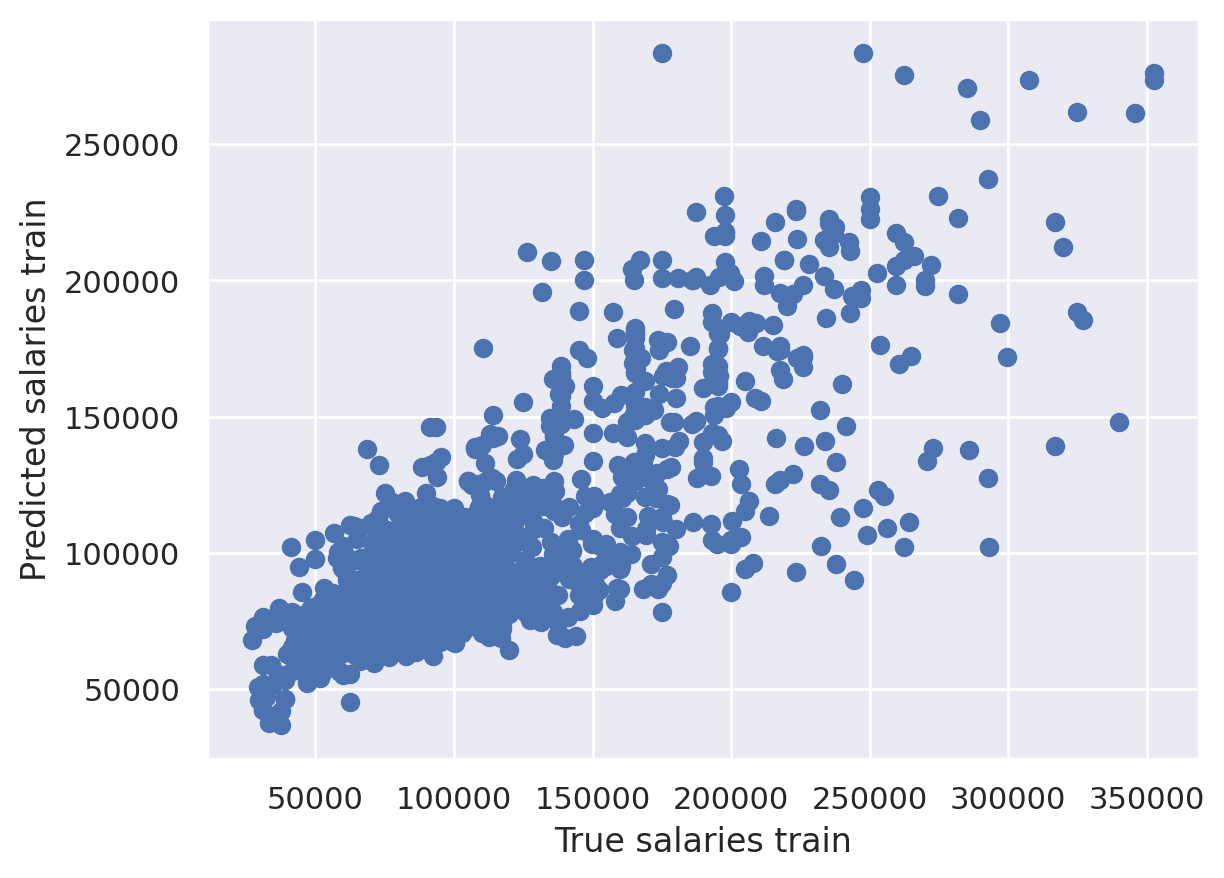

In [34]:
plt.scatter(y_train, grid_search_bow.predict(X_train_bow))
plt.xlabel('True salaries train')
plt.ylabel('Predicted salaries train')

In [35]:
r2 = r2_score(y_test, grid_search_bow.predict(X_test_bow))
print(r2)

0.5303965557742718


Text(0, 0.5, 'Predicted salaries test')

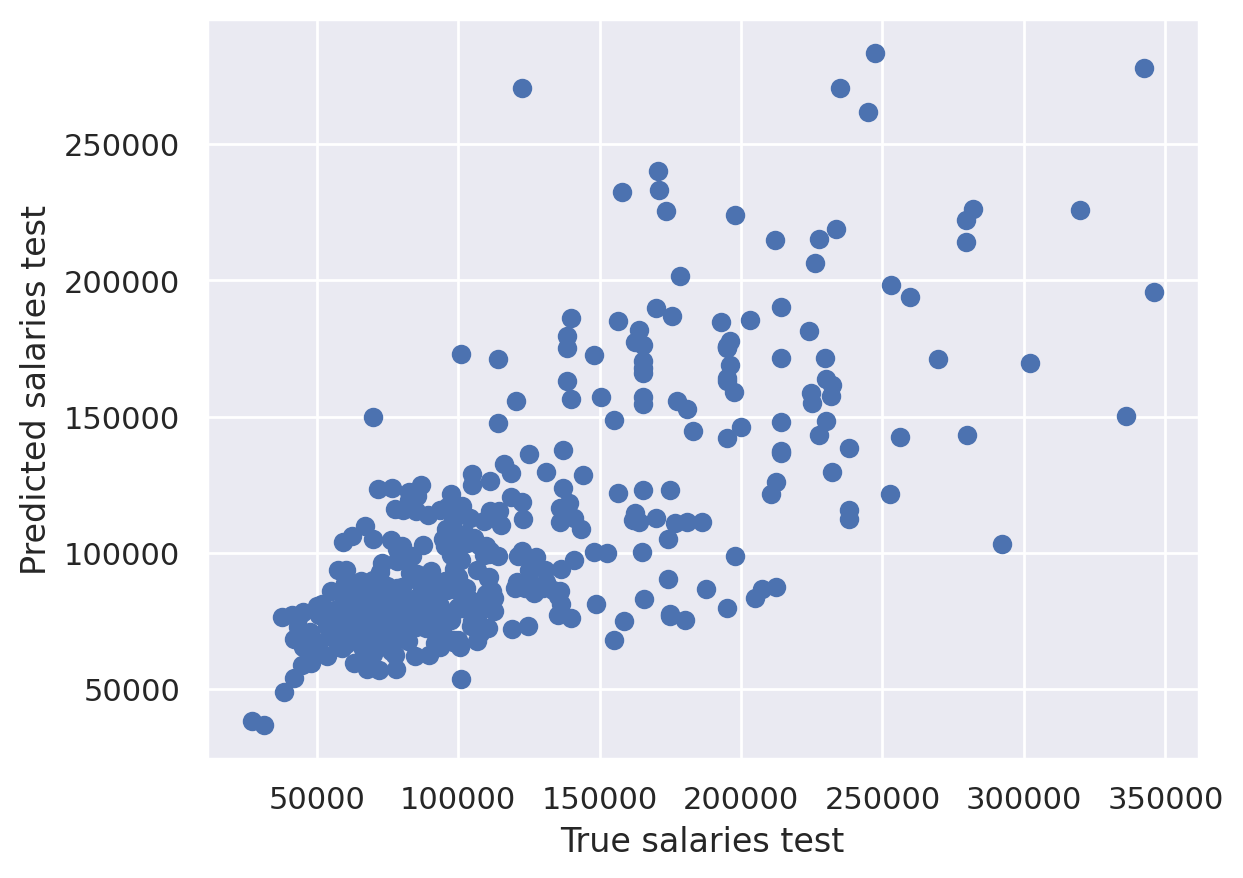

In [36]:
plt.scatter(y_test, grid_search_bow.predict(X_test_bow))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')

In [37]:
# Grid search CV for TFIDF
grid_search_tfidf = GridSearchCV(KNeighborsRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_tfidf.fit(X_train_tfidf, y_train)

best_params_tfidf = grid_search_tfidf.best_params_
tfidf_train_score = mean_squared_error(y_train, grid_search_tfidf.predict(X_train_tfidf))
tfidf_test_score = mean_squared_error(y_test, grid_search_tfidf.predict(X_test_tfidf))

print(f"Best parameters for TF-IDF: {best_params_tfidf}")
print(f"Train, test MSE for TF-IDF: {tfidf_train_score, tfidf_test_score}")

Best parameters for TF-IDF: {'n_neighbors': 20}
Train, test MSE for TF-IDF: (1024562278.0356703, 948950129.1577873)


In [38]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, grid_search_tfidf.predict(X_train_tfidf))
print(r2)

0.6896066443256498


Text(0, 0.5, 'Predicted salaries train')

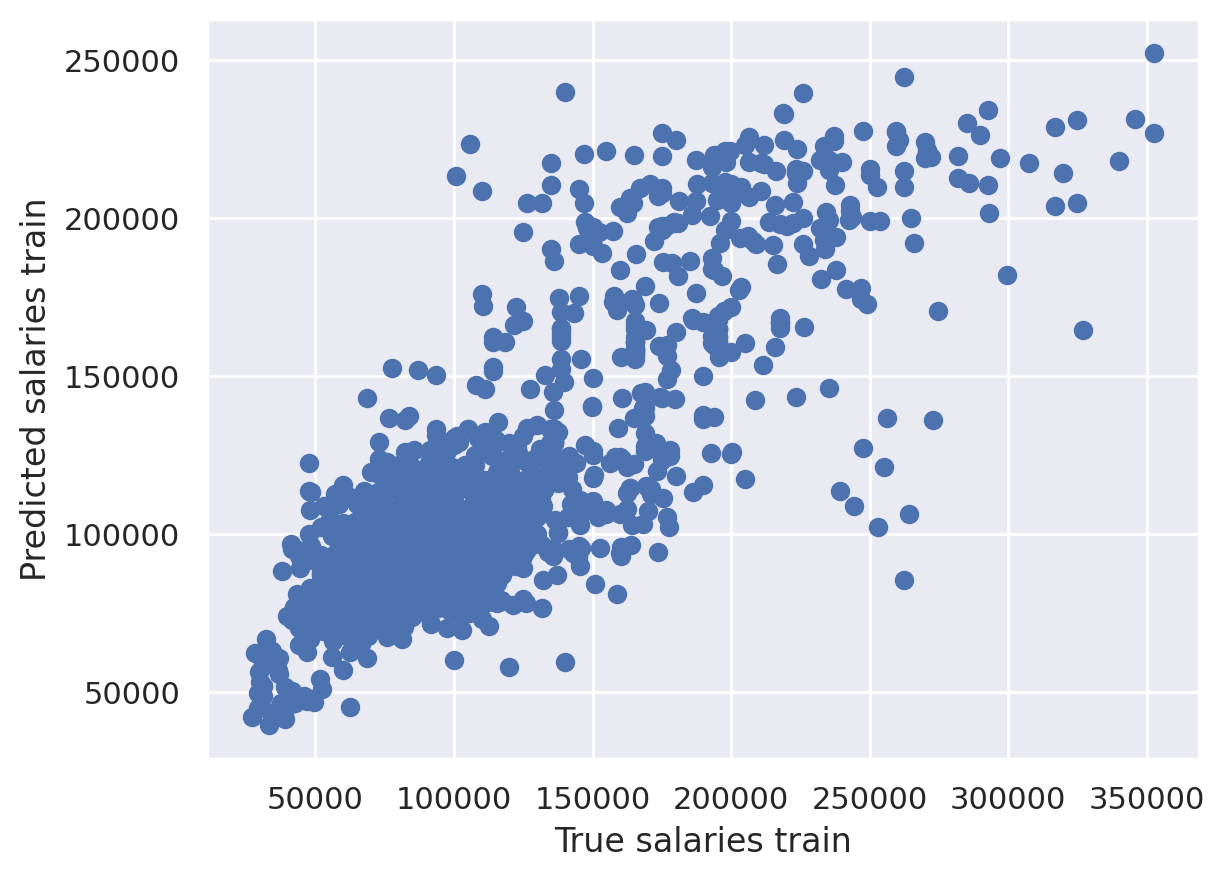

In [39]:
plt.scatter(y_train, grid_search_tfidf.predict(X_train_tfidf))
plt.xlabel('True salaries train')
plt.ylabel('Predicted salaries train')

In [40]:
r2 = r2_score(y_test, grid_search_tfidf.predict(X_test_tfidf))
print(r2)

0.7333024458755617


Text(0, 0.5, 'Predicted salaries test')

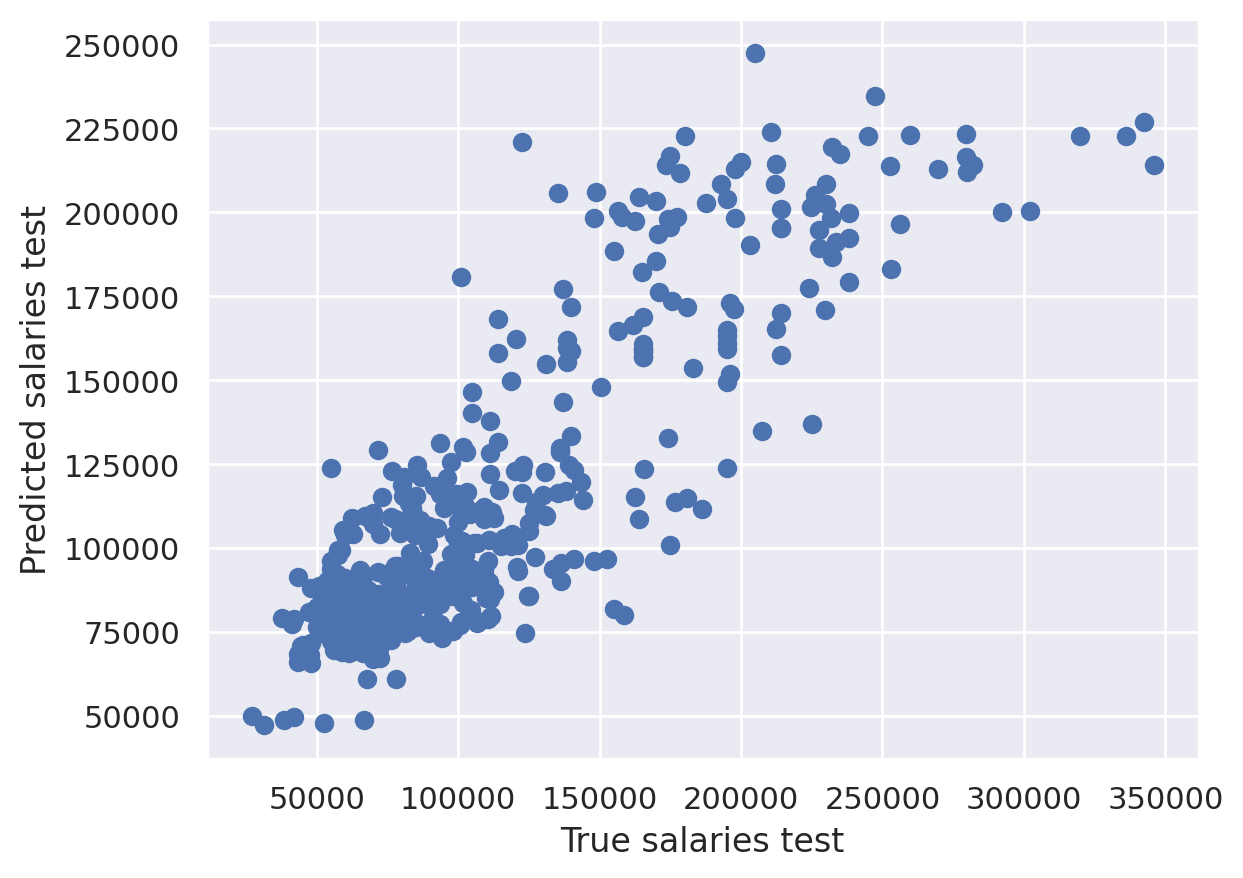

In [41]:
plt.scatter(y_test, grid_search_tfidf.predict(X_test_tfidf))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')

In [42]:
# Grid search CV for LDA
grid_search_lda = GridSearchCV(KNeighborsRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_lda.fit(X_train_lda, y_train)

best_params_lda = grid_search_lda.best_params_
lda_train_score = mean_squared_error(y_train, grid_search_lda.predict(X_train_lda))
lda_test_score = mean_squared_error(y_test, grid_search_lda.predict(X_test_lda))

print(f"Best parameters for LDA: {best_params_lda}")
print(f"Train, test MSE for LDA: {lda_train_score, lda_test_score}")

NameError: name 'X_train_lda' is not defined

In [ ]:
bow_pay = grid_search_bow.predict(X_test_bow)
tfidf_pay = grid_search_tfidf.predict(X_test_tfidf)
# lda_pay = grid_search_lda.predict(X_test_lda)

In [ ]:
test_idx = 250

print(f"K Nearest Neighbors Predictions:")
print(f"- BoW pay: {bow_pay[test_idx]:.1f}")
print(f"- TF-IDF pay: {tfidf_pay[test_idx]:.1f}")
# print(f"- LDA pay: {lda_pay[test_idx]:.1f}")
print(f"- Real pay: {y_test[test_idx]:.1f}")

###Classic Model: Random Forest Regressor

In [43]:
# Cross-validation parameters
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [30, 100, 150],
    'max_features': np.arange(0.2, 1.2, 0.4)
}
kfolds = 5
scoring = 'neg_mean_squared_error'

In [49]:
# Grid search CV for BOW
grid_search_bow = GridSearchCV(RandomForestRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_bow.fit(X_train_bow, y_train)

best_params_bow = grid_search_bow.best_params_
bow_train_score = mean_squared_error(y_train, grid_search_bow.predict(X_train_bow))
bow_test_score = mean_squared_error(y_test, grid_search_bow.predict(X_test_bow))

bow_r2_train = r2_score(y_train, grid_search_bow.predict(X_train_bow))
bow_r2_test = r2_score(y_test, grid_search_bow.predict(X_test_bow))

print(f"Best parameters for BOW: {best_params_bow}")
print(f"Train, test MSE for BOW: {bow_train_score, bow_test_score}")
print(f"Train, test R2 for TF-IDF: {bow_r2_train, bow_r2_test}")

Best parameters for BOW: {'max_depth': 150, 'max_features': 0.2, 'n_estimators': 200}
Train, test MSE for BOW: (137162348.88264018, 975481287.8104758)


In [ ]:
plt.scatter(y_train, grid_search_bow.predict(X_train_bow))
plt.xlabel('True salaries train')
plt.ylabel('Predicted salaries train')
plt.title("R2 scatter plot for bow train")


plt.scatter(y_test, grid_search_tfidf.predict(X_test_bow))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')
plt.title("R2 scatter plot for bow test")

In [50]:
from sklearn.metrics import r2_score

r2 = r2_score(y_train, grid_search_bow.predict(X_train_bow))
print(r2)

0.9584463700698764


Text(0, 0.5, 'Predicted salaries train')

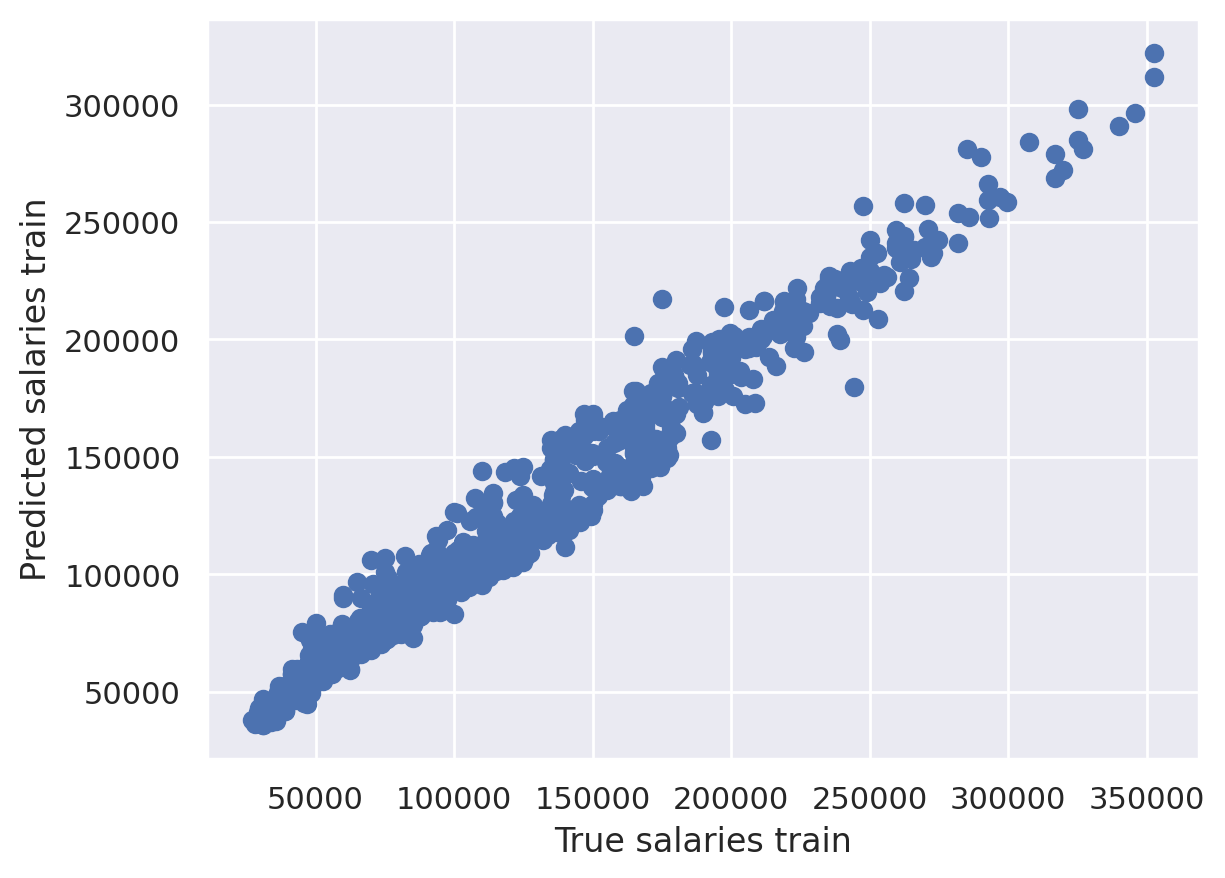

In [51]:
plt.scatter(y_train, grid_search_bow.predict(X_train_bow))
plt.xlabel('True salaries train')
plt.ylabel('Predicted salaries train')

In [52]:
r2 = r2_score(y_test, grid_search_bow.predict(X_test_bow))
print(r2)

0.7258460001643005


Text(0, 0.5, 'Predicted salaries test')

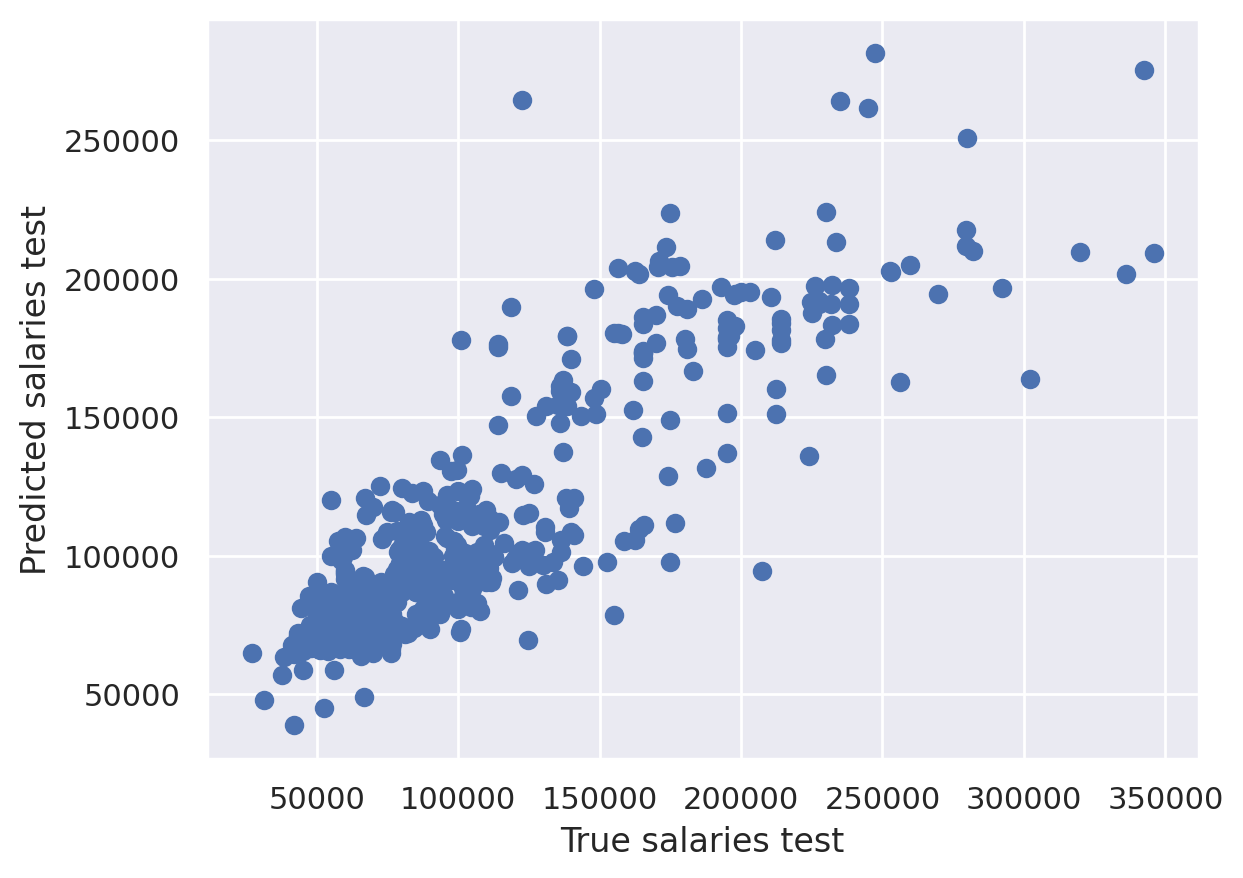

In [53]:
plt.scatter(y_test, grid_search_bow.predict(X_test_bow))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')

In [44]:
# Grid search CV for TFIDF
grid_search_tfidf = GridSearchCV(RandomForestRegressor(), param_grid, cv=kfolds, scoring=scoring, n_jobs=-1)
grid_search_tfidf.fit(X_train_tfidf, y_train)

best_params_tfidf = grid_search_tfidf.best_params_
tfidf_train_score = mean_squared_error(y_train, grid_search_tfidf.predict(X_train_tfidf))
tfidf_test_score = mean_squared_error(y_test, grid_search_tfidf.predict(X_test_tfidf))

tfidf_r2_train = r2_score(y_train, grid_search_tfidf.predict(X_train_tfidf))
tfidf_r2_test = r2_score(y_test, grid_search_tfidf.predict(X_test_tfidf))

print(f"Best parameters for TF-IDF: {best_params_tfidf}")
print(f"Train, test MSE for TF-IDF: {tfidf_train_score, tfidf_test_score}")
print(f"Train, test R2 for TF-IDF: {tfidf_r2_train, tfidf_r2_test}")

Best parameters for TF-IDF: {'max_depth': 30, 'max_features': 0.2, 'n_estimators': 200}
Train, test MSE for TF-IDF: (150074625.54578626, 970066085.3275921)


Text(0, 0.5, 'Predicted salaries train')

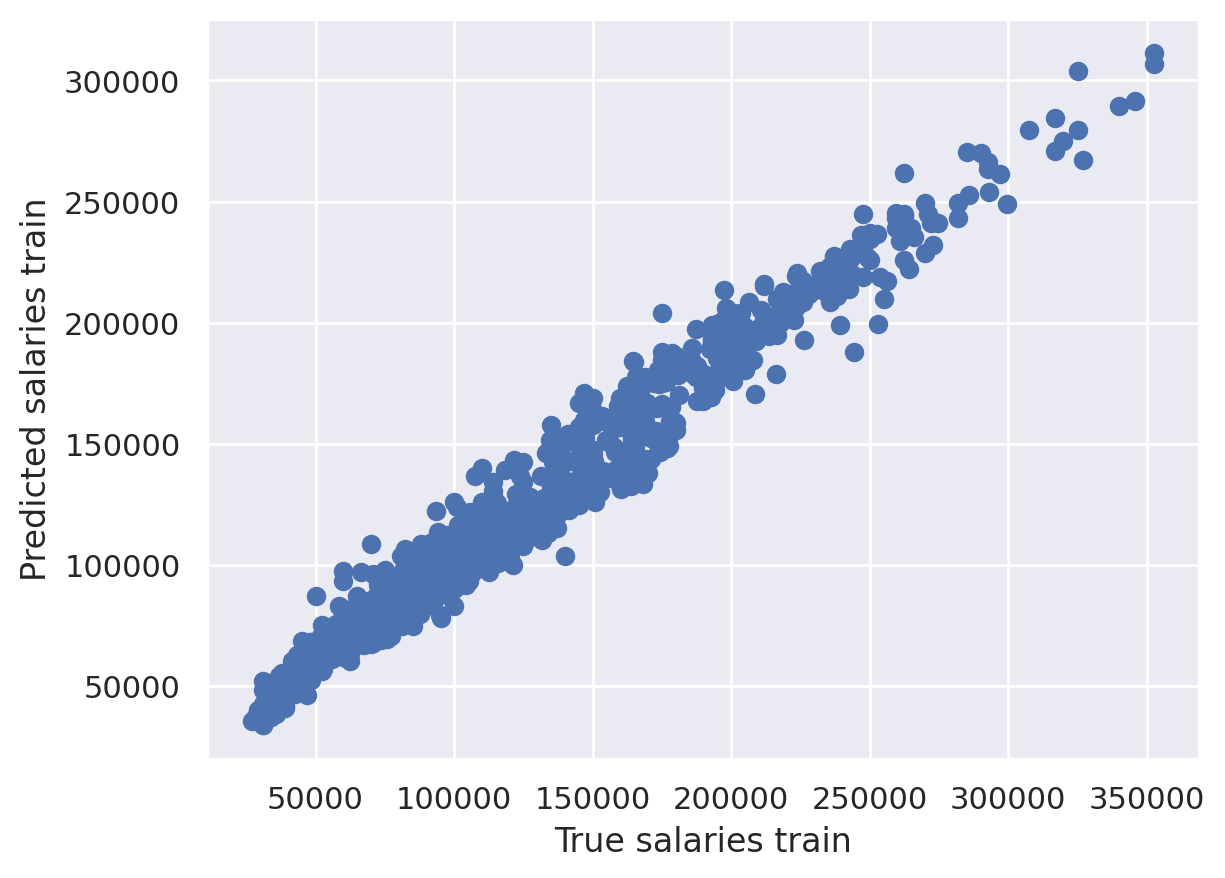

In [46]:
plt.scatter(y_train, grid_search_tfidf.predict(X_train_tfidf))
plt.xlabel('True salaries train')
plt.ylabel('Predicted salaries train')
plt.title("R2 scatter plot for tfidf train")


plt.scatter(y_test, grid_search_tfidf.predict(X_test_tfidf))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')
plt.title("R2 scatter plot for tfidf test")

In [47]:
r2 = r2_score(y_test, grid_search_tfidf.predict(X_test_tfidf))
print(r2)

0.727367914976152


Text(0, 0.5, 'Predicted salaries test')

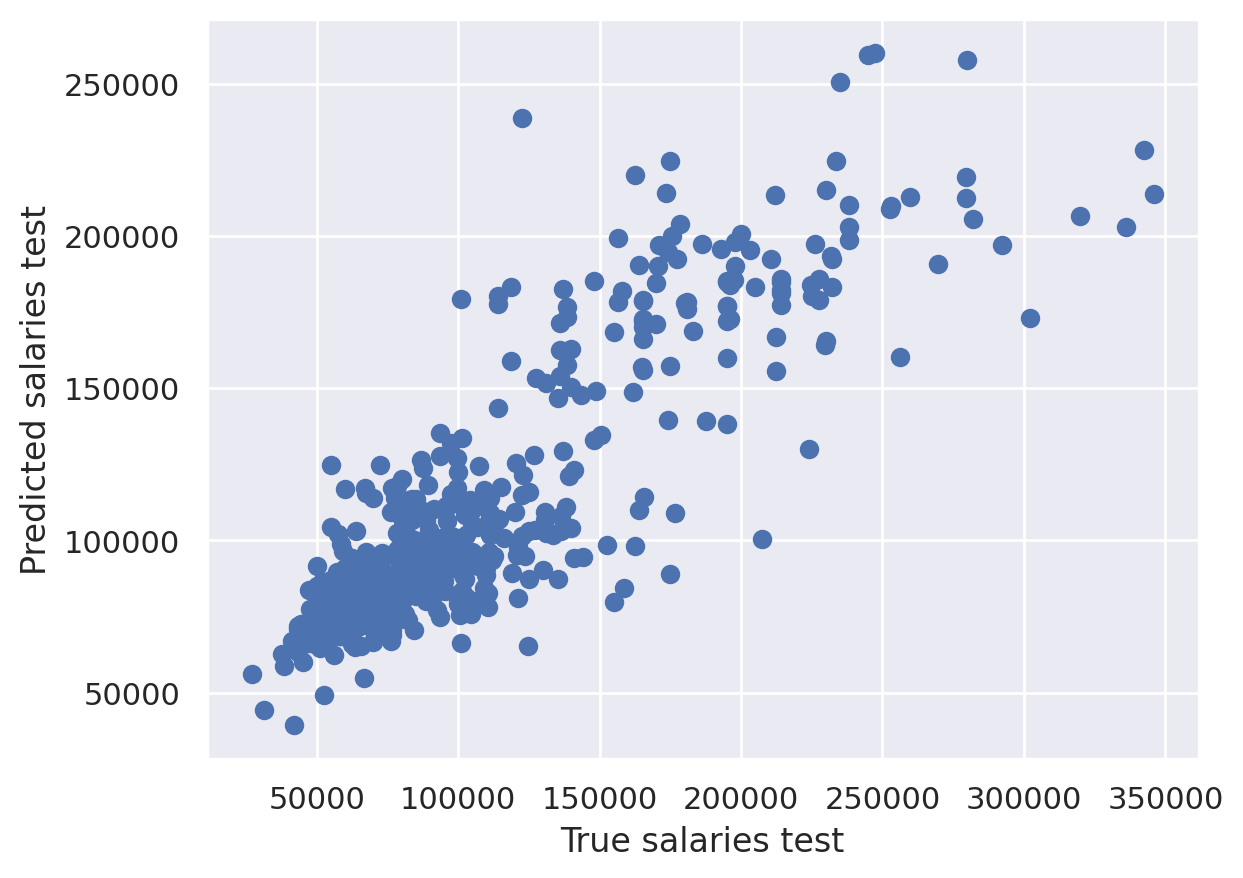

In [48]:
plt.scatter(y_test, grid_search_tfidf.predict(X_test_tfidf))
plt.xlabel('True salaries test')
plt.ylabel('Predicted salaries test')

### Transformers

In [ ]:
# TODO

## **5. Semantic Graph and Distances between Documents**

Convert to sparse matrix representation.

In [ ]:
with open(path + '/vectorizations/lda_corpus.pkl', 'rb') as f:
    LDA_corpus = pickle.load(f)

In [ ]:
# Convert from list of tuples to sparse matrix
LDA_sparse = gensim.matutils.corpus2csc(LDA_corpus).T
n_topics = LDA_sparse.shape[1]
n_docs = LDA_sparse.shape[0]

print(f"Number of topics: {n_topics}")
print(f"X: sparse matrix with {LDA_sparse.nnz} nonzero values out of {n_docs * n_topics}")
print(LDA_sparse.shape)

Number of topics: 20
X: sparse matrix with 18922 nonzero values out of 45400
(2270, 20)


Renormalize rows to get probabilistic embeddings.

In [ ]:
print(f"Average row sum before normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

LDA_sparse = scsp.csr_matrix(LDA_sparse / np.sum(LDA_sparse, axis=1))

print(f"Average row sum after normalizing: {np.mean(LDA_sparse.sum(axis=1).T)}")

Average row sum before normalizing: 0.9756703687172911
Average row sum after normalizing: 1.0


Compute Similarity matrix based on Battacharyya Coefficient.

In [ ]:
S = np.sqrt(LDA_sparse) * np.sqrt(LDA_sparse.T)

print(f"Shape of S: {S.shape}")
print(f"Number of non-zero elements: {S.nnz}")
print(f"Proportion of non-zero values: {S.nnz / (S.shape[0] * S.shape[1]) * 100:.3f}%")

Shape of S: (2270, 2270)
Number of non-zero elements: 5084144
Proportion of non-zero values: 98.666%


In [ ]:
S = scsp.triu(S, k=1) # Mantain upper triangular matrix
print('Number of non-zero components in S:', S.nnz)

Number of non-zero components in S: 2540937


Threshold similarity matrix to discard non important edges.

In [ ]:
n_nodes = LDA_sparse.shape[0]
n_edges = S.nnz
n_edges_per_node = n_edges / n_nodes

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of edges per node: {n_edges_per_node}")

Number of nodes: 2270
Number of edges: 2540937
Number of edges per node: 1119.3555066079296


Threshold: 0.7990467164056574
Number of edges: 56750


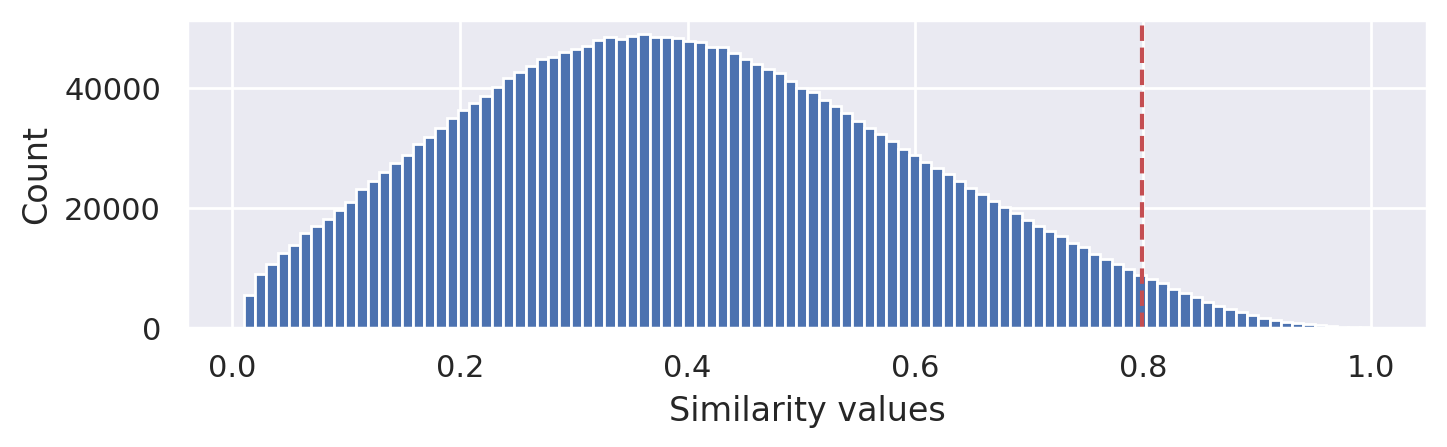

In [ ]:
n_edges_per_node = 25

n_edges = n_edges_per_node * n_nodes
sorted_sim = np.sort(S.data)[::-1]
thr = sorted_sim[n_edges]

print(f"Threshold: {thr}")
print(f"Number of edges: {n_edges}")

plt.figure(figsize=(8, 2))
plt.hist(S.data, bins=100)
plt.axvline(thr, linestyle='--', color='r')
plt.xlabel('Similarity values')
plt.ylabel('Count')
plt.show()

In [ ]:
S.data = np.where(S.data < thr, 0, S.data)
S.eliminate_zeros()

Plot graph and compute layout.

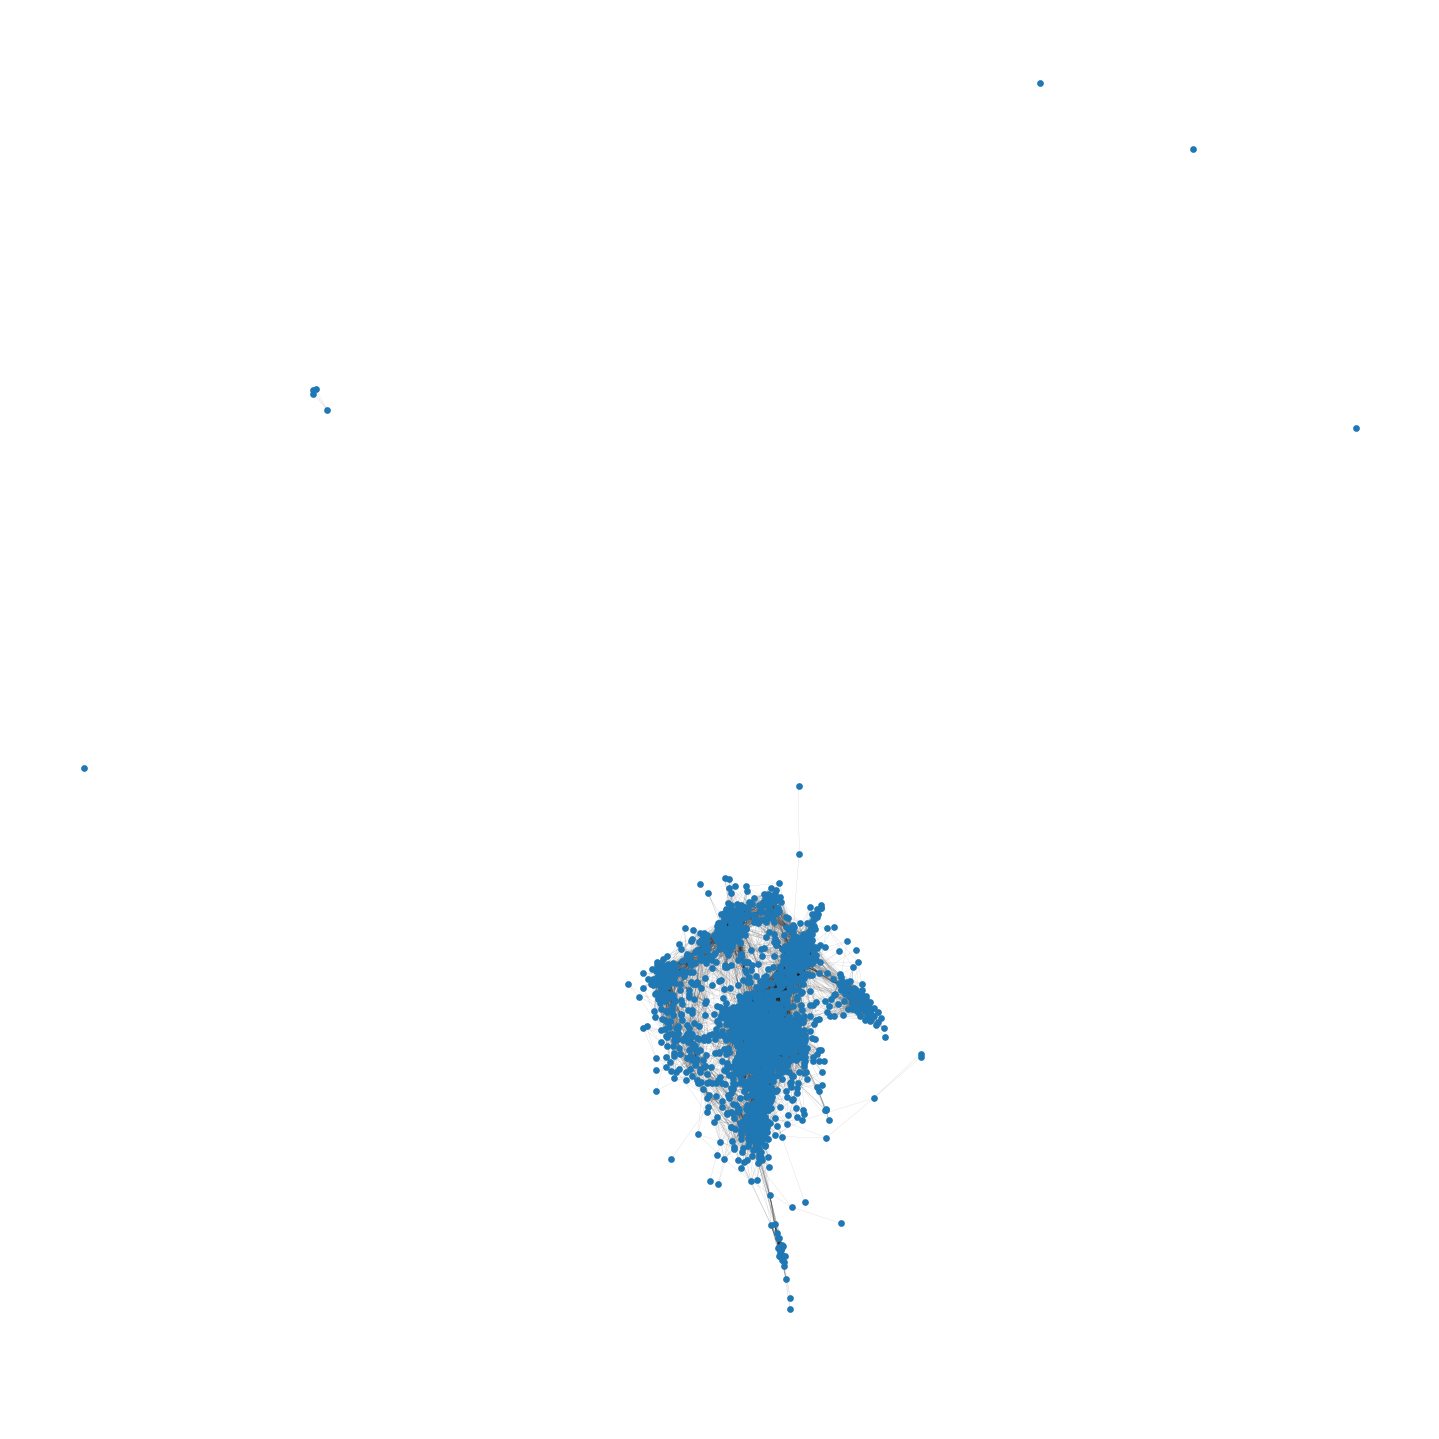

In [ ]:
G = nx.from_scipy_sparse_array(S)
positions = nx.spring_layout(G, iterations=50, seed=0)

plt.figure(figsize=(7,7))
nx.draw(G, positions, node_size=2, width=0.02)

Find the largest connected component.

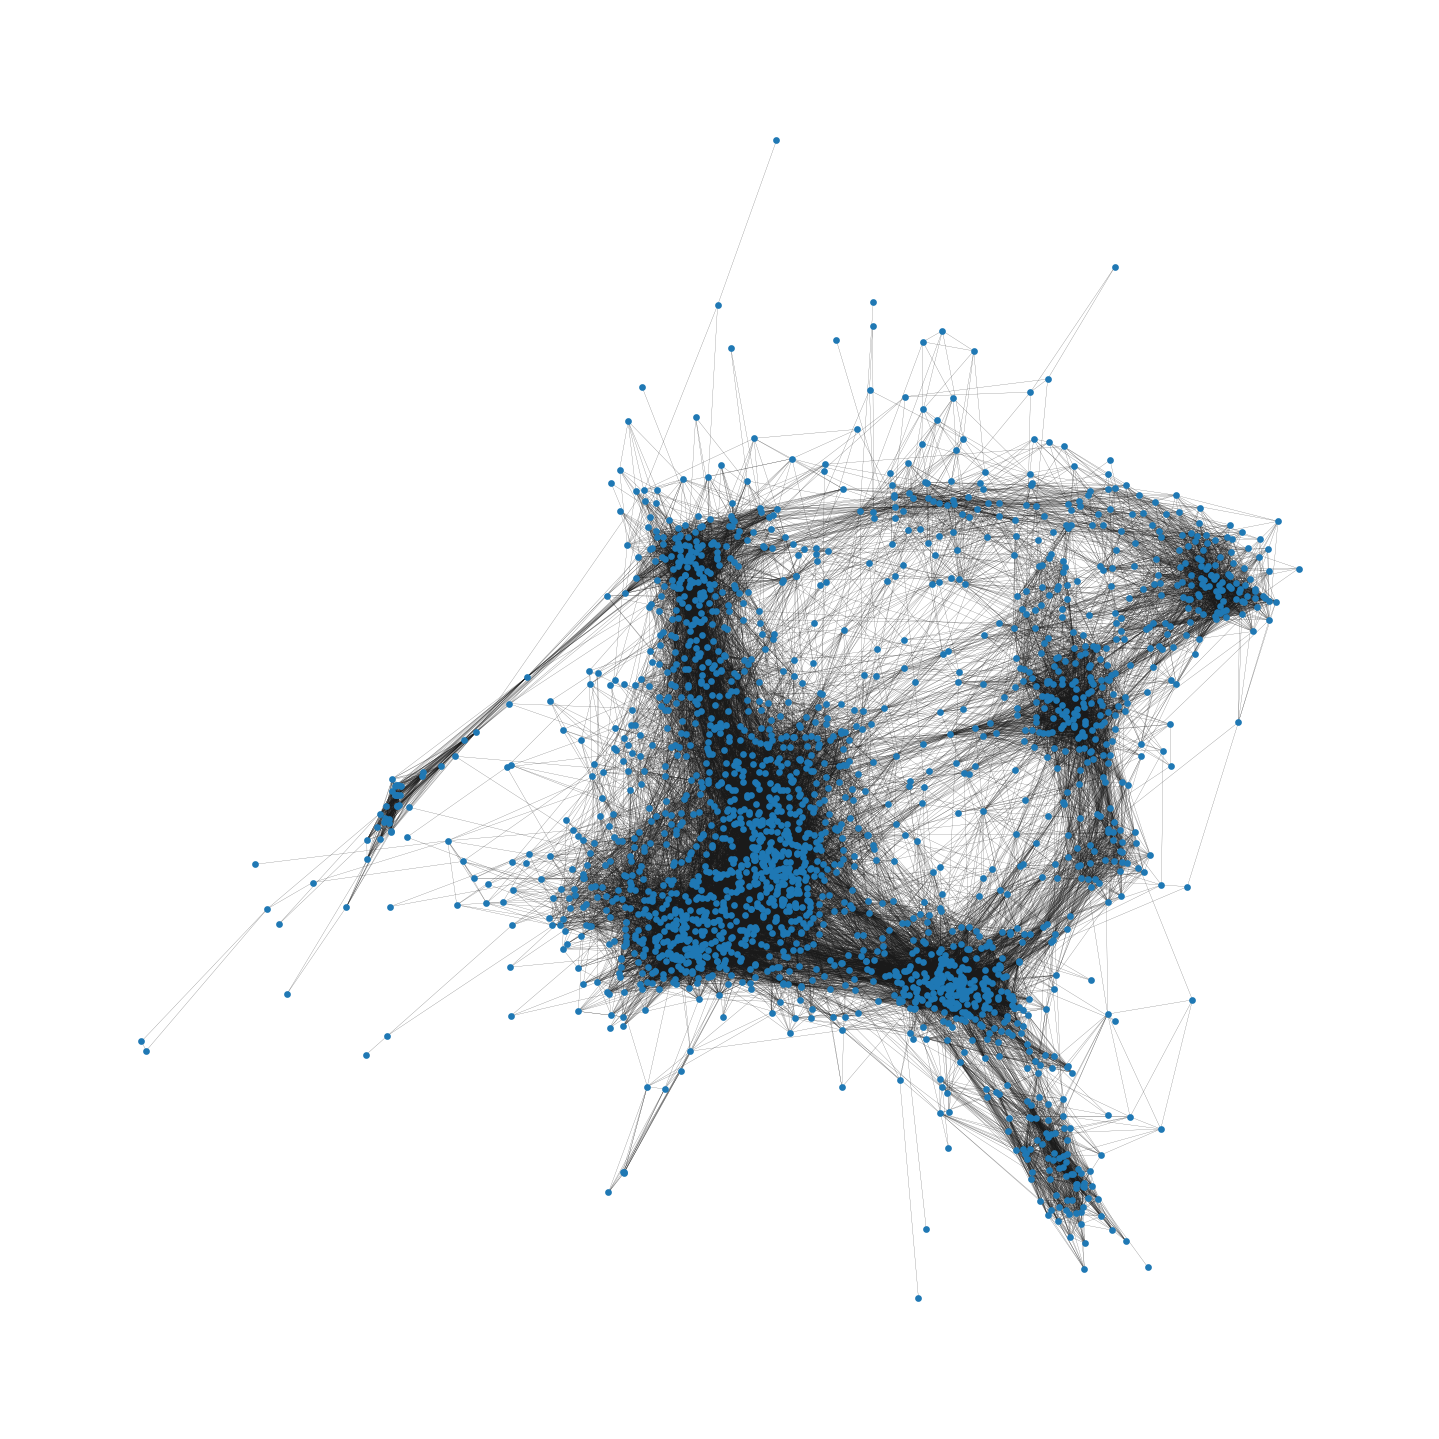

In [ ]:
nodes_lcc = list(nx.connected_components(G))[0]

fig = plt.figure(figsize=(7, 7))
G_lcc = G.subgraph(nodes_lcc)
positions_lcc = nx.spring_layout(G_lcc, iterations=50, seed=0)

nx.draw(G_lcc, positions_lcc, node_size=2, width=0.06)
fig.show()

Community detection algorithm to explore semantic structure of corpus and similarities between documents.

In [ ]:
C = nx.community.louvain_communities(G_lcc, seed=0)

# Metrics of the partition
modularity = nx.community.modularity(G_lcc, C)
coverage, performance = nx.community.partition_quality(G_lcc, C)

nc = len(C)
print(f"Number of communities: {nc}")
print(f"Modularity: {modularity}")
print(f"Coverage: {coverage}")
print(f"Performance: {performance}")

Number of communities: 12
Modularity: 0.7175539024558223
Coverage: 0.8551414221517314
Performance: 0.9011028116398032


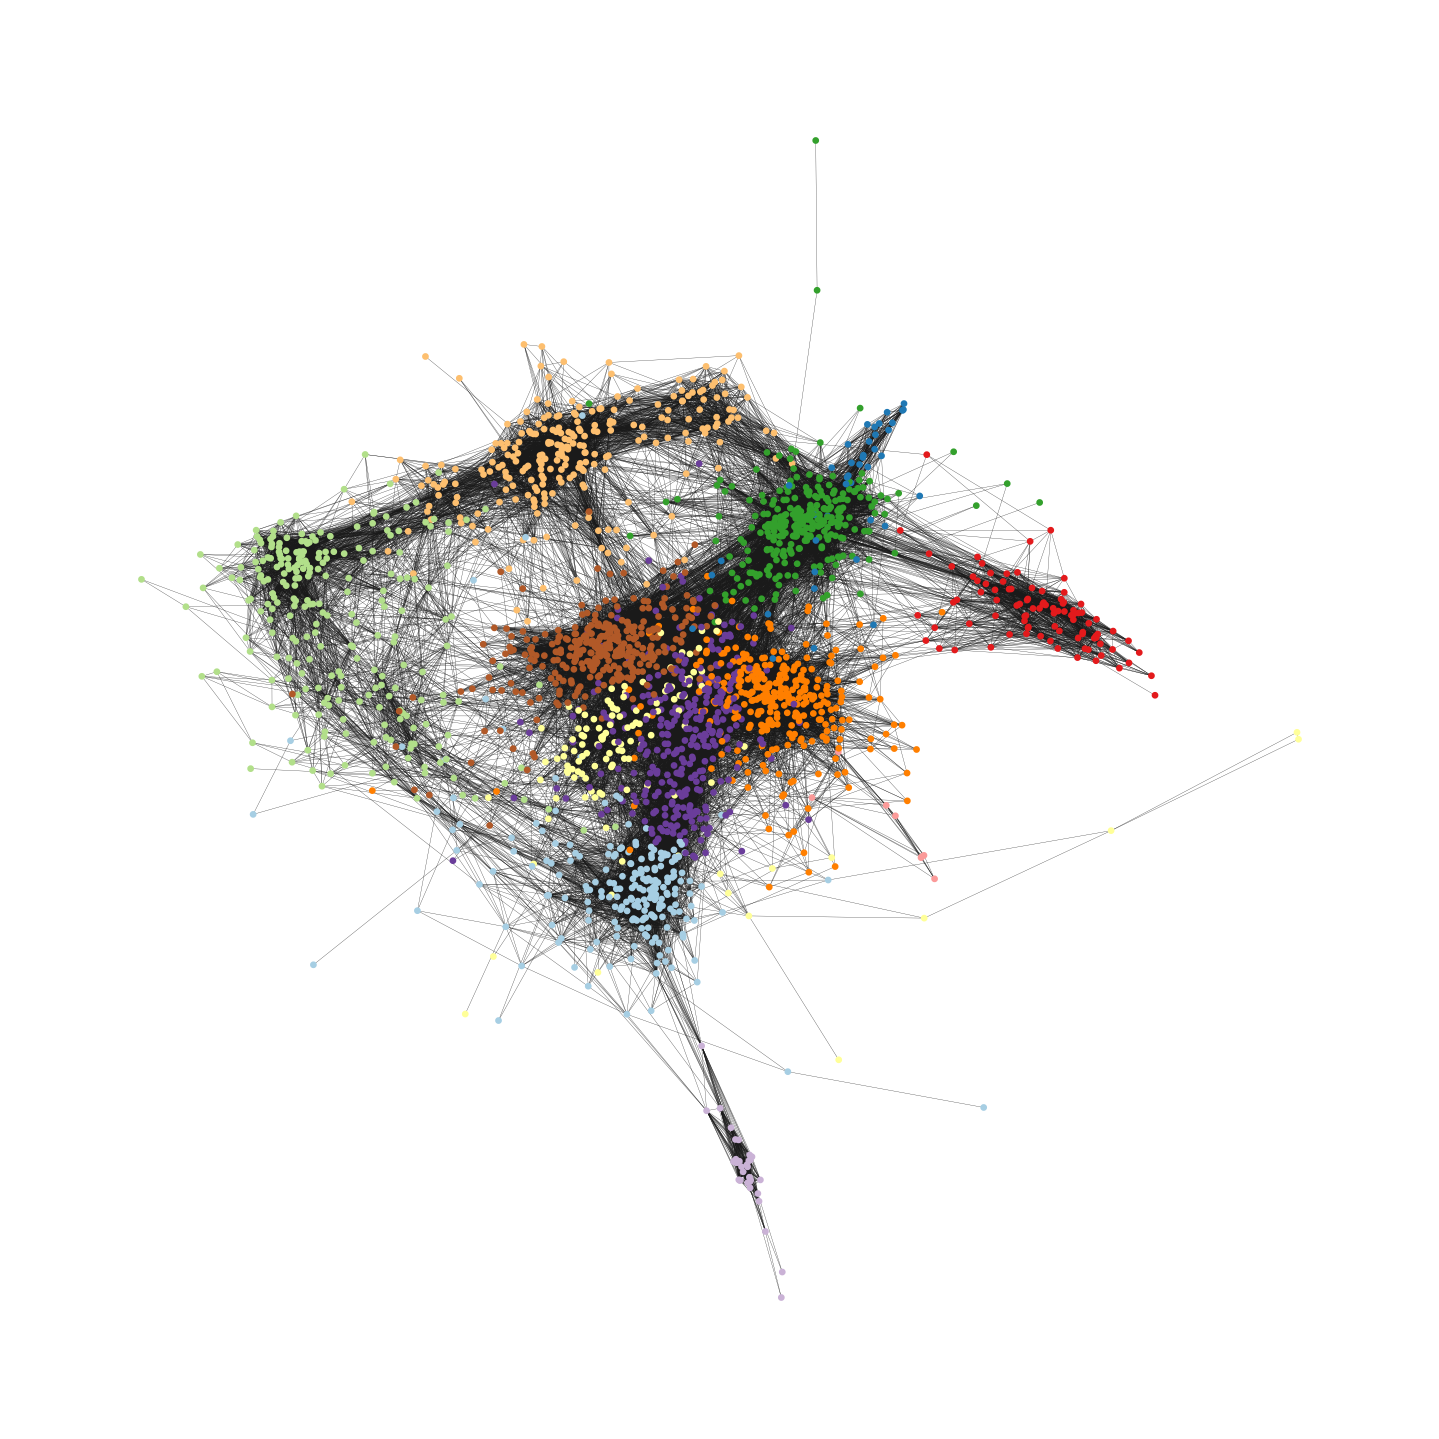

In [ ]:
palette = sns.color_palette(palette="Paired", n_colors=nc)

node2comm = {n: 0 for n in G_lcc}
for i, com in enumerate(C):
    for node in list(com):
        node2comm[node] = i

# Map node attribute to rgb colors
node_colors = [palette[node2comm[n]] for n in G_lcc]

#  Draw graph
plt.figure(figsize=(7, 7))
nx.draw(G_lcc, positions, node_size=2, node_color=node_colors, width=0.1)

## **6. Extension Work**

In [ ]:
# TDOD